<ipython-input-48-16f413dd511b>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


best-1 Grad-CAM kaydedildi: /content/best_1_gradcam.jpg
best-1 Grad-CAM++ kaydedildi: /content/best_1_gradcampp.jpg


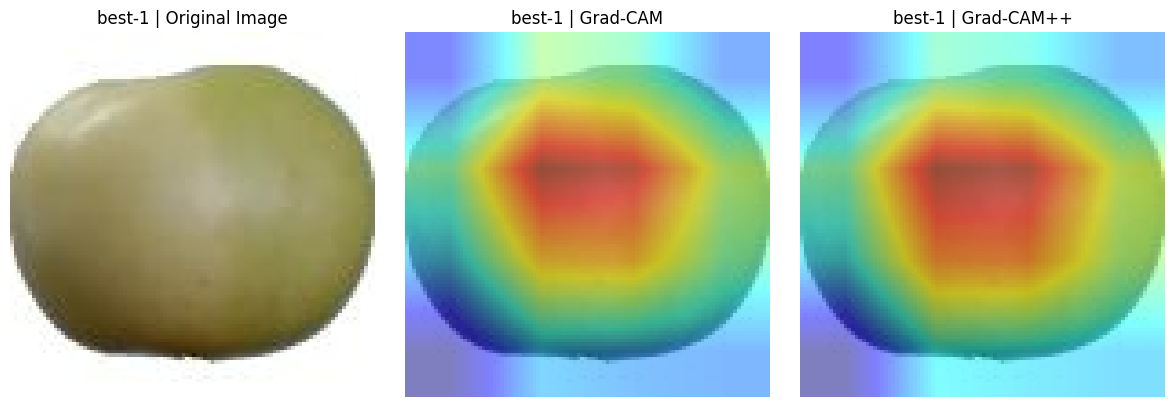

best-2 Grad-CAM kaydedildi: /content/best_2_gradcam.jpg
best-2 Grad-CAM++ kaydedildi: /content/best_2_gradcampp.jpg


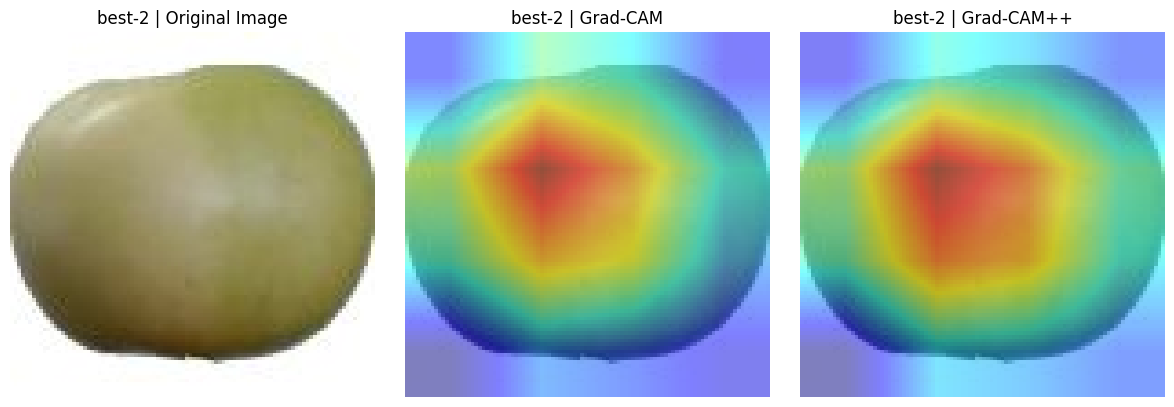

best-3 Grad-CAM kaydedildi: /content/best_3_gradcam.jpg
best-3 Grad-CAM++ kaydedildi: /content/best_3_gradcampp.jpg


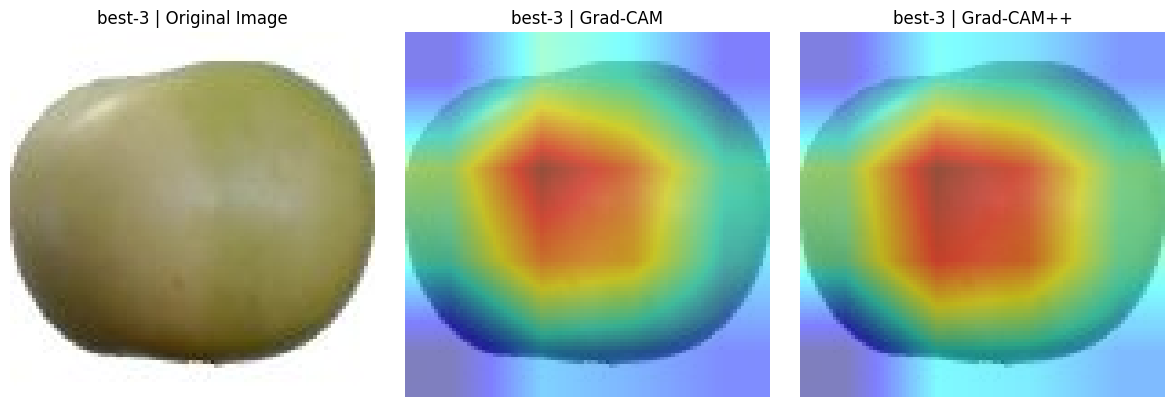

best-4 Grad-CAM kaydedildi: /content/best_4_gradcam.jpg
best-4 Grad-CAM++ kaydedildi: /content/best_4_gradcampp.jpg


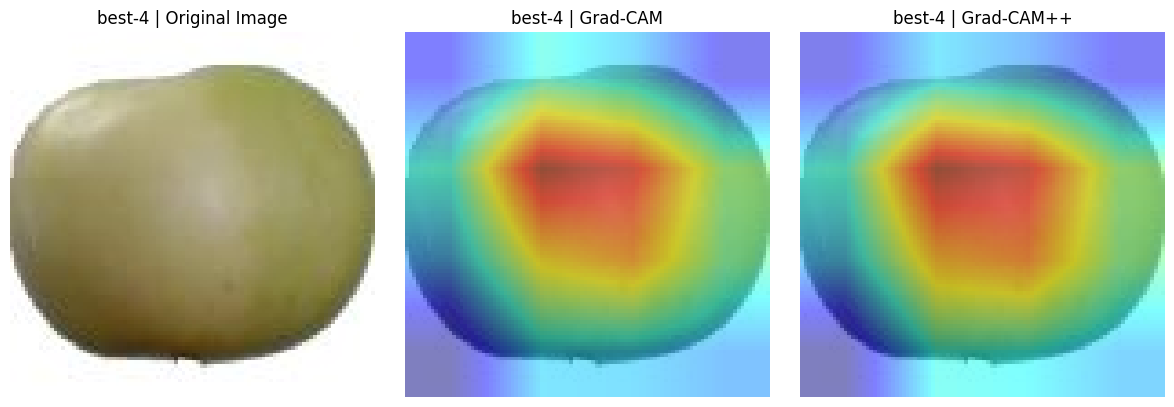

best-5 Grad-CAM kaydedildi: /content/best_5_gradcam.jpg
best-5 Grad-CAM++ kaydedildi: /content/best_5_gradcampp.jpg


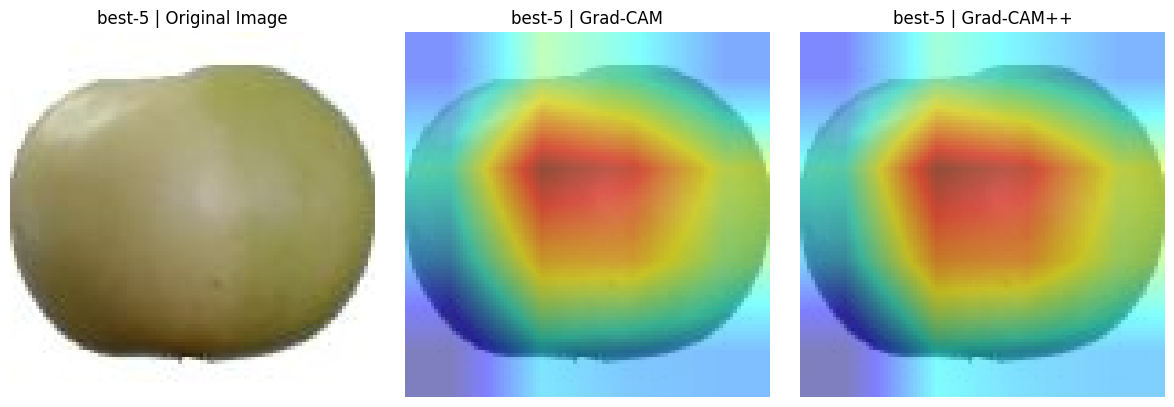

worst-1 Grad-CAM kaydedildi: /content/worst_1_gradcam.jpg
worst-1 Grad-CAM++ kaydedildi: /content/worst_1_gradcampp.jpg


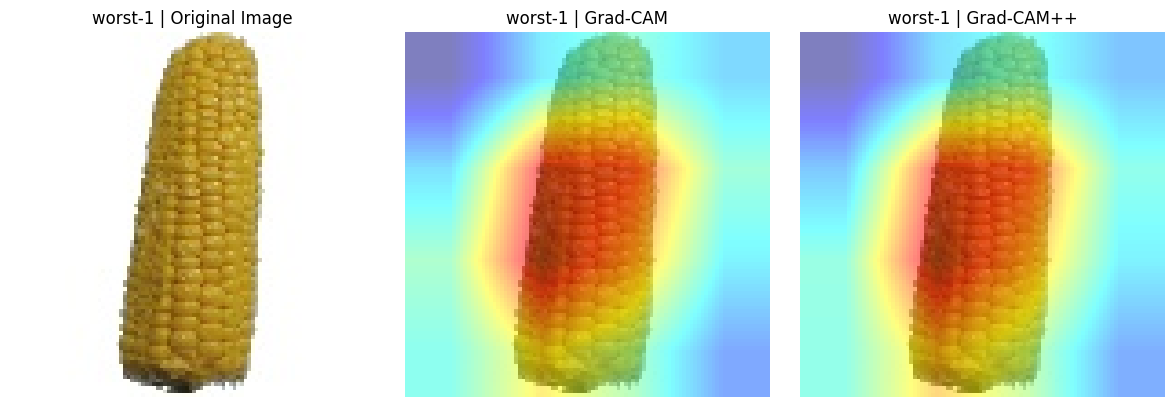

worst-2 Grad-CAM kaydedildi: /content/worst_2_gradcam.jpg
worst-2 Grad-CAM++ kaydedildi: /content/worst_2_gradcampp.jpg


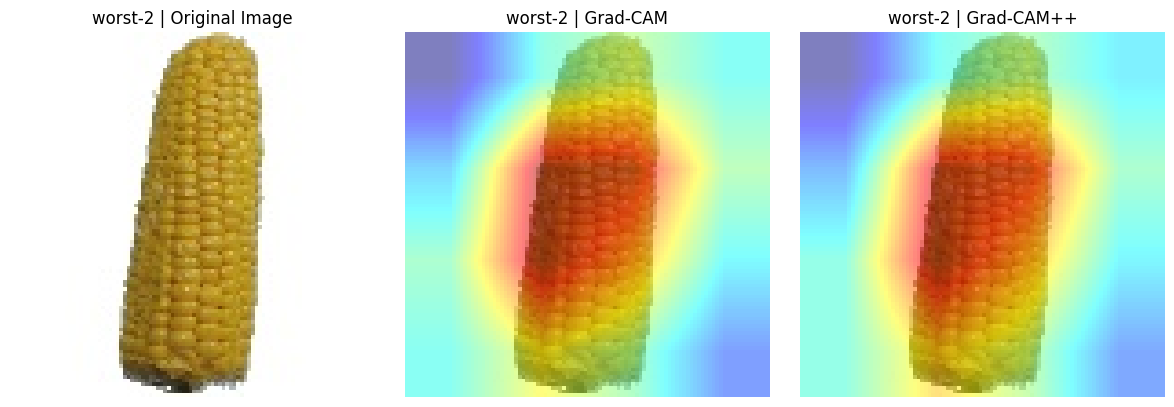

worst-3 Grad-CAM kaydedildi: /content/worst_3_gradcam.jpg
worst-3 Grad-CAM++ kaydedildi: /content/worst_3_gradcampp.jpg


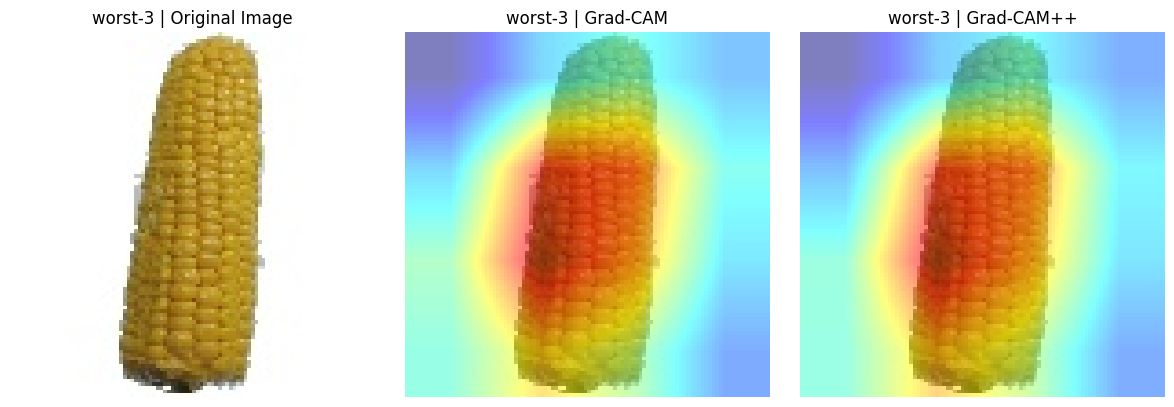

worst-4 Grad-CAM kaydedildi: /content/worst_4_gradcam.jpg
worst-4 Grad-CAM++ kaydedildi: /content/worst_4_gradcampp.jpg


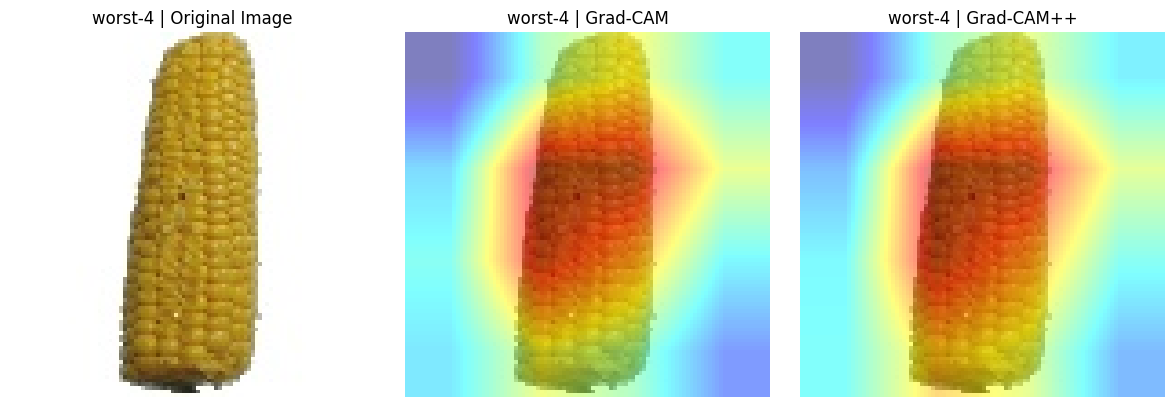

worst-5 Grad-CAM kaydedildi: /content/worst_5_gradcam.jpg
worst-5 Grad-CAM++ kaydedildi: /content/worst_5_gradcampp.jpg


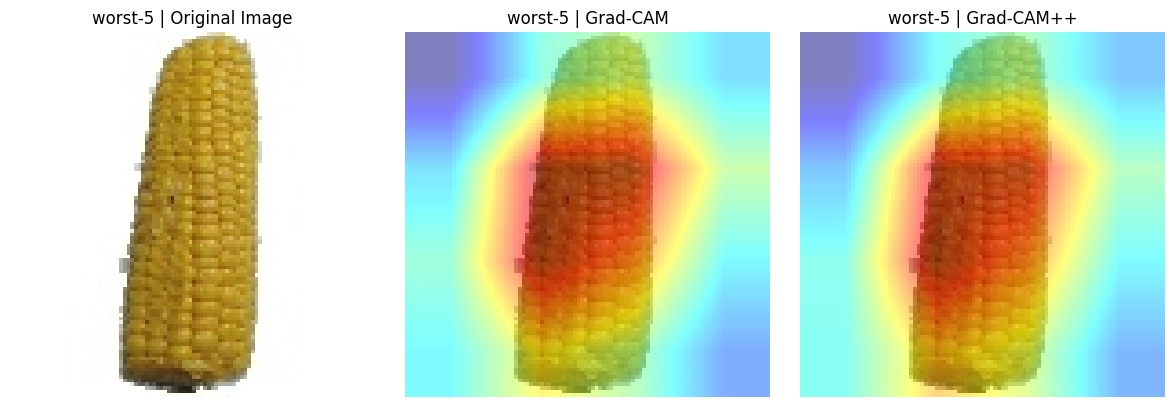

In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image


def load_custom_resnet50(model_path, device):
    """
    Daha önce kaydedilmiş PyTorch tabanlı (ResNet50 veya benzeri) modeli yükler.
    """
    model = torch.load(model_path, map_location=device)
    model.eval()  # Modeli değerlendirme moduna al
    return model


def gradcam_and_gradcampp(model, image_path, output_dir, target_layers, prefix, index):
    """
    Grad-CAM ve Grad-CAM++ görselleştirmelerini üretir, kaydeder ve ekranda gösterir.

    Args:
        model (torch.nn.Module): Yüklü PyTorch modeli.
        image_path (str): İncelenecek görüntünün dosya yolu.
        output_dir (str): Çıktıların kaydedileceği dizin.
        target_layers (list): Grad-CAM için hedef katman(lar).
        prefix (str): 'best' veya 'worst' gibi bir ön ek.
        index (int): Görüntü sıra numarası (1'den başlayabilir).
    """
    # Görüntüyü yükleme ve ön işleme
    original_img = cv2.imread(image_path, 1)[:, :, ::-1]  # BGR -> RGB
    if original_img is None:
        print(f"HATA: '{image_path}' dosyası yüklenemedi.")
        return

    original_img = np.float32(original_img) / 255.0
    input_tensor = preprocess_image(
        original_img,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # Çıktı dizinini oluşturma
    os.makedirs(output_dir, exist_ok=True)

    # 1) Grad-CAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        gradcam_image = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
        gradcam_image_bgr = cv2.cvtColor(gradcam_image, cv2.COLOR_RGB2BGR)

        gradcam_path = os.path.join(output_dir, f"{prefix}_{index}_gradcam.jpg")
        cv2.imwrite(gradcam_path, gradcam_image_bgr)
        print(f"{prefix}-{index} Grad-CAM kaydedildi: {gradcam_path}")

    # 2) Grad-CAM++
    with GradCAMPlusPlus(model=model, target_layers=target_layers) as campp:
        grayscale_campp = campp(input_tensor=input_tensor, targets=None)
        grayscale_campp = grayscale_campp[0, :]

        gradcampp_image = show_cam_on_image(original_img, grayscale_campp, use_rgb=True)
        gradcampp_image_bgr = cv2.cvtColor(gradcampp_image, cv2.COLOR_RGB2BGR)

        gradcampp_path = os.path.join(output_dir, f"{prefix}_{index}_gradcampp.jpg")
        cv2.imwrite(gradcampp_path, gradcampp_image_bgr)
        print(f"{prefix}-{index} Grad-CAM++ kaydedildi: {gradcampp_path}")

    # Görselleştirme
    show_visualizations(original_img, gradcam_image, gradcampp_image, prefix, index)


def show_visualizations(original_img, gradcam_image, gradcampp_image, prefix, index):
    """
    Orijinal görüntü, Grad-CAM ve Grad-CAM++ çıktılarını ekranda yan yana gösterir.
    (Isı haritalarını ayrıca kaydettiğimiz için burada yalnızca bindirilmiş sonuçlar gösteriliyor.)
    """
    plt.figure(figsize=(12, 4))

    # Orijinal görüntü
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f"{prefix}-{index} | Original Image")
    plt.axis("off")

    # Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_image)
    plt.title(f"{prefix}-{index} | Grad-CAM")
    plt.axis("off")

    # Grad-CAM++
    plt.subplot(1, 3, 3)
    plt.imshow(gradcampp_image)
    plt.title(f"{prefix}-{index} | Grad-CAM++")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    #####################
    #  A N A  K I S I M
    #####################
    # Cihaz seçimi
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Modeli yükleme
    model_path = "/content/resnet50_fine_tuned_model.pth"  # VGG16'nızı PyTorch tabanlı kaydettiyseniz aynı dosya yolu
    model = load_custom_resnet50(model_path, device)

    # Hedef katman (örn. VGG16'daki son konvolüsyon)
    # Modelinizi print ederek hangisinin son conv katmanı olduğunu doğrulayın
    target_layers = [model.layer4[-1]]

    # 5 adet en iyi sınıf görüntüsü
    best_images = [
        "/content/r0_11_100.jpg",
        "/content/r0_15_100.jpg",
        "/content/r0_19_100.jpg",
        "/content/r0_3_100.jpg",
        "/content/r0_7_100.jpg"
    ]

    # 5 adet en kötü sınıf görüntüsü (örnek)
    worst_images = [
        "/content/19_100.jpg",
        "/content/20_100.jpg",
        "/content/21_100.jpg",
        "/content/2_100.jpg",
        "/content/9_100.jpg"
    ]

    # Çıktı dizini
    output_dir = "/content"

    # En iyi sınıf
    for i, img_path in enumerate(best_images, start=1):
        gradcam_and_gradcampp(model, img_path, output_dir, target_layers, prefix="best", index=i)

    # En kötü sınıf
    for i, img_path in enumerate(worst_images, start=1):
        gradcam_and_gradcampp(model, img_path, output_dir, target_layers, prefix="worst", index=i)
